https://github.com/riannevdberg/sylvester-flows/blob/master/optimization/loss.py

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optims
from keras.datasets import mnist

import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


Using TensorFlow backend.


In [ ]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def log_norm_diag(value, mean = None, log_var = None, dim = 1):
    if mean is not None and log_var is not None:
        log_norm = -(value - mean)**2
        log_norm *= torch.reciprocal(2.*log_var.exp())
        log_norm += -0.5 * log_var
    else:
        log_norm = -0.5 * (value) ** 2
        
    return torch.mean(log_norm, dim = 1)

class RealNVP(nn.Module):
    def __init__(self, z0_dim, hidden_dim, n_flow):
        super().__init__()
        
        scale_net = lambda: nn.Sequential(nn.Linear(z0_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, z0_dim))
        trans_net = lambda: nn.Sequential(nn.Linear(z0_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, z0_dim))
        mask = np.ones((z0_dim,))
        mask[:int(z0_dim/2)] = 0        
        f_mask = [1 - mask, mask] * int(n_flow/2)
        
        self.scale_net = nn.ModuleList(scale_net() for i in range(len(f_mask)))
        self.trans_net = nn.ModuleList(trans_net() for i in range(len(f_mask)))
        self.mask = nn.Parameter(torch.tensor(f_mask).type('torch.FloatTensor'), requires_grad = False)
        
    def z2x(self, z0, generate_mode = False):
        x = z0
        log_det_j = 0
        for i in range(len(self.mask)):
            x_ = x * self.mask[i]
            s = self.scale_net[i](x_) * (1 - self.mask[i])
            t = self.trans_net[i](x_) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_j -= torch.sum(s,dim = 1)
        if generate_mode:
            return x
        else:
            return x, log_det_j
        
    def forward(self, z0, generate_mode = False):
        return self.z2x(z0, generate_mode)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, with_normalizing_flow = False,n_flow = 5):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.with_normalizing_flow = with_normalizing_flow
        
        self.encoder = self.build_encoder(input_dim, hidden_dim)
        self.decoder = self.build_decoder(hidden_dim, input_dim)
        self.h_mean = nn.Sequential(nn.Linear(hidden_dim, 64),nn.ReLU(),nn.Linear(64, 64), nn.ReLU(), nn.Linear(64,hidden_dim))
        self.h_std = nn.Sequential(nn.Linear(hidden_dim, 64),nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64,hidden_dim))
        self.device = torch.device('cpu')
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        if self.with_normalizing_flow:
            self.flow = RealNVP(hidden_dim, hidden_dim, n_flow)
        
        
    def generate(self, batch_size):
        z = np.random.normal(size = (batch_size, self.hidden_dim))
        z = torch.tensor(z).type('torch.FloatTensor').to(self.device)
        
        if self.with_normalizing_flow:
            z = self.flow(z, True)
            
        output = self.decoder(z)
        return output
    
    def build_encoder(self, input_dim, output_dim):
        model = nn.Sequential(nn.Linear(input_dim,32),nn.ReLU(),nn.Linear(32,output_dim))
        return model
    
    def build_decoder(self, input_dim, output_dim):
        model = nn.Sequential(nn.Linear(input_dim,32), nn.ReLU(), nn.Linear(32, output_dim))
        return model
    
    def reparameter_trick(self, z_mean, z_std):
        batch_size, feature_dim = z_std.size()
        epsilon = np.random.normal(size = (batch_size, feature_dim))
        epsilon = torch.tensor(epsilon).type('torch.FloatTensor').to(self.device)
        z = z_mean + epsilon * torch.exp(z_std)
        return z
    
    def forward(self, x):
        batch_size = x.size()[0]
        
        encode_ = self.encoder(x)
        z_mean = self.h_mean(encode_)
        z_std = self.h_std(encode_)    ##z_std := log_var
        z = self.reparameter_trick(z_mean, z_std)      

        if not self.with_normalizing_flow:
            decode_ = self.decoder(z)
            reconstruction_loss = torch.sum((x - decode_) ** 2)/batch_size
            kl_loss = torch.sum(-0.5 * (1 + z_std - z_mean ** 2 - torch.exp(z_std)))
            loss = reconstruction_loss + kl_loss
        else:
            zk, log_det_j = self.flow(z)    
            qz_log_norm = log_norm_diag(z, z_mean, z_std)
            pz_log_norm = log_norm_diag(zk)
            decode_ = self.decoder(zk)
            reconstruction_loss = torch.sum((x - decode_) ** 2)/batch_size
            kl_loss = torch.sum(qz_log_norm - pz_log_norm)/batch_size + torch.sum(log_det_j)/batch_size 
            loss = reconstruction_loss + kl_loss
        #loss = reconstruction_loss
        return loss, kl_loss, reconstruction_loss, log_det_j, decode_

In [ ]:
vae_nf = VAE(784, 2, True)
optim = optims.Adam(vae_nf.parameters())

In [ ]:
x_data = x_train.reshape(-1, 784)

In [ ]:
epochs = 10000

In [ ]:
for epoch in range(epochs):
    batch_index = np.random.choice(len(x_data),20)
    batch_x = x_data[batch_index]/255.0
    batch_x = torch.tensor(batch_x).type('torch.FloatTensor').to(device)
    loss, kl_loss, reconstruction_loss, log_det_j, output = vae_nf(batch_x)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if epoch % 100 == 0:
        print("Loss :",loss.detach().cpu().numpy(),'kl_loss :',kl_loss.detach().cpu().numpy(),"reconstruction_loss :",reconstruction_loss.detach().cpu().numpy())

Loss : 34.89923 kl_loss : -5.092659 reconstruction_loss : 39.99189
Loss : 36.35741 kl_loss : -5.0722947 reconstruction_loss : 41.429707
Loss : 37.93788 kl_loss : -4.9335074 reconstruction_loss : 42.871387
Loss : 29.85212 kl_loss : -5.368594 reconstruction_loss : 35.220715
Loss : 30.868114 kl_loss : -5.5294485 reconstruction_loss : 36.397564
Loss : 31.470705 kl_loss : -5.300036 reconstruction_loss : 36.77074
Loss : 33.688583 kl_loss : -5.235546 reconstruction_loss : 38.92413
Loss : 34.22064 kl_loss : -5.48512 reconstruction_loss : 39.705757
Loss : 31.520529 kl_loss : -5.6058598 reconstruction_loss : 37.12639
Loss : 31.425167 kl_loss : -5.5493197 reconstruction_loss : 36.974487
Loss : 33.518703 kl_loss : -5.5864215 reconstruction_loss : 39.105125
Loss : 35.907642 kl_loss : -5.947168 reconstruction_loss : 41.85481
Loss : 30.153553 kl_loss : -5.888142 reconstruction_loss : 36.041695
Loss : 36.65612 kl_loss : -5.7079854 reconstruction_loss : 42.364105
Loss : 36.87844 kl_loss : -5.5969896 re

KeyboardInterrupt: ignored

In [ ]:
def plot_result(output):
    batch_size = output.size()[0]
    output = output.detach().cpu().numpy()
    output = output.reshape((batch_size, 28,28))
    output = np.clip(output, a_min = 0.0, a_max = 1.0)
    plt.subplots(1, batch_size,figsize = (25,25))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(output[i], cmap = 'gray')
    plt.show()

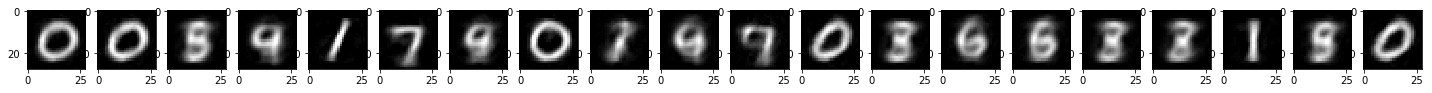

In [ ]:
plot_result(output)

In [ ]:
print(output.size())

torch.Size([20, 784])


In [ ]:
gaussian_sample = np.random.normal(size = (100000,2))
gaussian_sample = torch.Tensor(gaussian_sample).type('torch.FloatTensor').to(device)

In [ ]:
x, _ = vae_nf.flow.z2x(gaussian_sample)

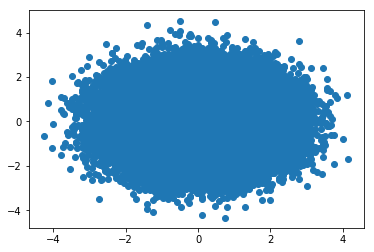

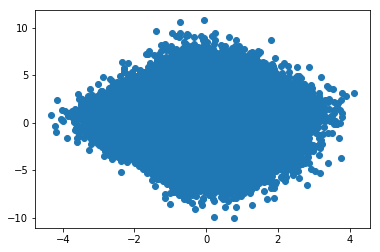

In [ ]:
x = x.detach().cpu().numpy()
plt.scatter(gaussian_sample[:,0],gaussian_sample[:,1])
plt.show()
plt.scatter(x[:,0],x[:,1])

實作過程中突然發現Loss變成Nan，一部份是因為計算gaussian機率時有問題，另一個關鍵錯誤是在flow的過程中是 x = x_ + (1 - self.mask[i]) * (<font color = 'red'>x</font> * torch.exp(s) + t)，是x而不是x_，x_後面早就被mask調拉，哪有辦法乘阿。